In [1]:
import snowflake.connector

# snowflake 데이터베이스 연결
conn = snowflake.connector.connect(
    user='Parksungsoo',
    password='4535Sfkpss3971',
    account='PSB20803',  
    warehouse='COMPUTE_WH',
)

In [2]:
import pandas as pd

####################### 1. 백화점 데이터
# 커서 생성 및 쿼리 실행
cursor = conn.cursor()
cursor.execute("SELECT * FROM DEPARTMENT_STORE_FOOT_TRAFFIC_FOR_SNOWFLAKE_STREAMLIT_HACKATHON.PUBLIC.SNOWFLAKE_STREAMLIT_HACKATHON_LOPLAT_DEPARTMENT_STORE_DATA")
# 전체 데이터를 DataFrame으로 저장
department_store_df = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])


####################### 2. 서울 기온 및 강수량 데이터
# 커서 생성 및 쿼리 실행
cursor = conn.cursor()
cursor.execute("SELECT * FROM SEOUL_TEMPERATURE__RAINFALL_FOR_SNOWFLAKE_STREAMLIT_HACKATHON.PUBLIC.SNOWFLAKE_STREAMLIT_HACKATHON_LOPLAT_SEOUL_TEMPERATURE_RAINFALL")
# 전체 데이터를 DataFrame으로 저장
seoul_weather_df = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])


####################### 3. 주거지/근무지 데이터
# 커서 생성 및 쿼리 실행
cursor = conn.cursor()
cursor.execute("SELECT * FROM RESIDENTIAL__WORKPLACE_TRAFFIC_PATTERNS_FOR_SNOWFLAKE_STREAMLIT_HACKATHON.PUBLIC.SNOWFLAKE_STREAMLIT_HACKATHON_LOPLAT_HOME_OFFICE_RATIO;")
# 전체 데이터를 DataFrame으로 저장
home_office_df = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])





####################### 1. 유동 인구 데이터
# 커서 생성 및 쿼리 실행
cursor = conn.cursor()
cursor.execute("SELECT * FROM SEOUL_DISTRICTLEVEL_DATA_FLOATING_POPULATION_CONSUMPTION_AND_ASSETS.GRANDATA.FLOATING_POPULATION_INFO")
# 전체 데이터를 DataFrame으로 저장
floating_population_df = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])


####################### 2. 신한카드 사용 데이터
# 커서 생성 및 쿼리 실행
cursor = conn.cursor()
cursor.execute("SELECT * FROM SEOUL_DISTRICTLEVEL_DATA_FLOATING_POPULATION_CONSUMPTION_AND_ASSETS.GRANDATA.CARD_SALES_INFO")
# 전체 데이터를 DataFrame으로 저장
card_sales_df = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])


####################### 3. 소득 데이터
# 커서 생성 및 쿼리 실행
cursor = conn.cursor()
cursor.execute("SELECT * FROM SEOUL_DISTRICTLEVEL_DATA_FLOATING_POPULATION_CONSUMPTION_AND_ASSETS.GRANDATA.ASSET_INCOME_INFO;")
# 전체 데이터를 DataFrame으로 저장
asset_income_df = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])


####################### 4. 행정동 경계 데이터
# 커서 생성 및 쿼리 실행
cursor = conn.cursor()
cursor.execute("SELECT * FROM SEOUL_DISTRICTLEVEL_DATA_FLOATING_POPULATION_CONSUMPTION_AND_ASSETS.GRANDATA.M_SCCO_MST;")
# 전체 데이터를 DataFrame으로 저장
scco_df = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])

스노우플레이크 커넥트 라이브러리를 활용하여 데이터베이스와 연결하여 쿼리문을통해 데이터를 변수명에 저장

In [3]:
ds_weather_df = pd.merge(
    department_store_df,
    seoul_weather_df,
    on='DATE_KST',
    how='left'
)

In [4]:
fp_card_df = pd.merge(
    floating_population_df,
    card_sales_df,
    on=['STANDARD_YEAR_MONTH', 'DISTRICT_CODE', 'AGE_GROUP', 'GENDER', 'TIME_SLOT', 'WEEKDAY_WEEKEND'],
    how='inner'
)

In [5]:
fp_card_asset = pd.merge(
    fp_card_df,
    asset_income_df,
    on=['STANDARD_YEAR_MONTH', 'DISTRICT_CODE', 'AGE_GROUP', 'GENDER'],
    how='inner'
)

In [6]:
fp_card_scco_asset = pd.merge(
    fp_card_asset,
    scco_df,
    on=['DISTRICT_CODE'],
    how='inner'
)

C:\Users\82106\AppData\Local\Temp\ipykernel_24760\263647221.py:1: FutureWarning: Passing 'suffixes' which cause duplicate columns {'PROVINCE_CODE_x', 'CITY_CODE_x'} in the result is deprecated and will raise a MergeError in a future version.
  fp_card_scco_asset = pd.merge(


공통 칼럼을 활용하여, 데이터 병합을 진행

In [7]:
# 필요 없는 컬럼 삭제
fp_card_scco_asset = fp_card_scco_asset.drop(columns=['PROVINCE_CODE_y', 'CITY_CODE_y'])

In [8]:
# 컬럼명 변경
fp_card_scco_asset = fp_card_scco_asset.rename(columns={
    'PROVINCE_CODE_x': 'PROVINCE_CODE',
    'CITY_CODE_x': 'CITY_CODE'
})

중복되는 칼럼을 삭제하고 칼럼명을 변경해준다.

### 전체인구, 엔터전체매출, 소비활력지수 계산

In [9]:
#한글폰트
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 경로 설정
font_path = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

In [10]:
import numpy as np

# 인구 합계 컬럼 생성 (거주+근무+방문 인구)
fp_card_scco_asset['전체인구'] = (
    fp_card_scco_asset['RESIDENTIAL_POPULATION'] +
    fp_card_scco_asset['WORKING_POPULATION'] +
    fp_card_scco_asset['VISITING_POPULATION']
)

# 인스타 감성 소비 매출 합계 컬럼 생성 (FOOD + COFFEE + BEAUTY + ENTERTAINMENT + SPORTS/CULTURE/LEISURE + TRAVEL)
fp_card_scco_asset['엔터전체매출'] = (
    fp_card_scco_asset['FOOD_SALES'] +
    fp_card_scco_asset['COFFEE_SALES'] + 
    fp_card_scco_asset['BEAUTY_SALES'] +
    fp_card_scco_asset['ENTERTAINMENT_SALES'] +
    fp_card_scco_asset['SPORTS_CULTURE_LEISURE_SALES'] +
    fp_card_scco_asset['TRAVEL_SALES']+
    fp_card_scco_asset['CLOTHING_ACCESSORIES_SALES']
)

소비활력지수 = 엔터매출 / 전체인구 = 한 사람당 평균적으로 얼마나 엔터테인먼트에 소비했는지

In [ ]:
# 엔터 관련 count 칼럼만 선택
enter_count_columns = [
    'FOOD_COUNT',
    'COFFEE_COUNT',
    'BEAUTY_COUNT',
    'ENTERTAINMENT_COUNT',
    'SPORTS_CULTURE_LEISURE_COUNT',
    'TRAVEL_COUNT',
    'CLOTHING_ACCESSORIES_COUNT'
]

# 엔터 관련 방문횟수 합계 컬럼 생성
fp_card_scco_asset['엔터전체방문자수'] = fp_card_scco_asset[enter_count_columns].sum(axis=1)

In [ ]:
# 2) 활동밀도(1인당 감성 소비액) 계산
fp_card_scco_asset['엔터활동밀도'] = (
    fp_card_scco_asset['엔터전체매출'] /
    fp_card_scco_asset['전체인구'].replace(0, np.nan)  # 0으로 나누기 방지
)

### 지역별 방문자수 순위

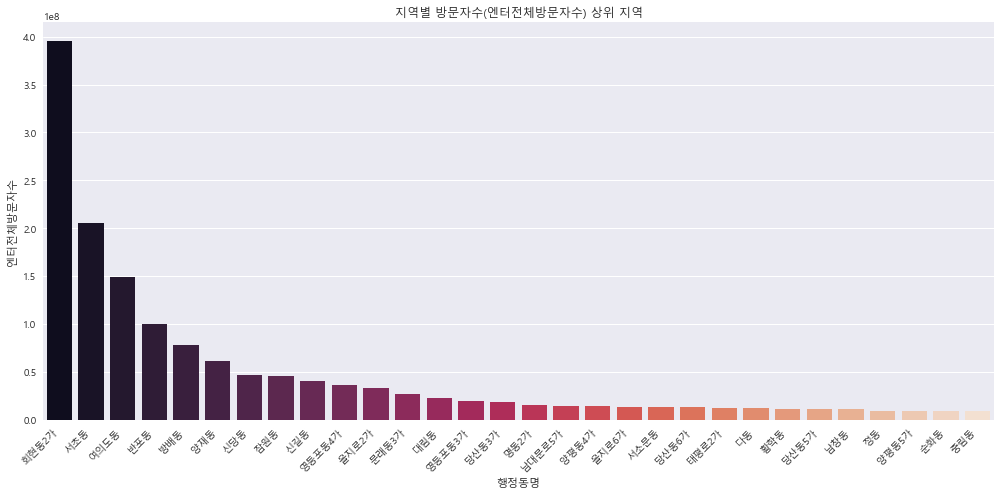

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 지역별 방문자수 합계 집계
agg = fp_card_scco_asset.groupby('DISTRICT_KOR_NAME')['엔터전체방문자수'].sum().reset_index()

# 2. 방문자수 내림차순 정렬
agg = agg.sort_values('엔터전체방문자수', ascending=False).head(30)

# 3. 바차트 시각화
plt.figure(figsize=(14, 7))
sns.barplot(data=agg, x='DISTRICT_KOR_NAME', y='엔터전체방문자수', palette='rocket')
plt.title('지역별 방문자수(엔터전체방문자수) 상위 지역')
plt.xlabel('행정동명')
plt.ylabel('엔터전체방문자수')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<Figure size 864x720 with 0 Axes>

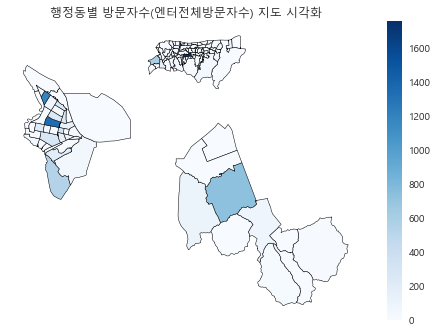

In [44]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import json
from shapely.geometry import shape

# 1. GeoDataFrame 생성 (GeoJSON 형식일 경우)
def geojson_to_shape(geojson_str):
    return shape(json.loads(geojson_str))

gdf = fp_card_scco_asset[['DISTRICT_KOR_NAME', '엔터전체방문자수', 'DISTRICT_GEOM']].drop_duplicates('DISTRICT_KOR_NAME').copy()
gdf['geometry'] = gdf['DISTRICT_GEOM'].apply(geojson_to_shape)
gdf = gpd.GeoDataFrame(gdf, geometry='geometry')

# 2. 좌표계 지정 (위경도라고 가정)
gdf.set_crs(epsg=4326, inplace=True)

# 3. 지도 시각화 (GeoPandas + matplotlib)
plt.figure(figsize=(12, 10))
gdf.plot(
    column='엔터전체방문자수',
    cmap='Blues',
    legend=True,
    edgecolor='black',
    linewidth=0.5
)
plt.title('행정동별 방문자수(엔터전체방문자수) 지도 시각화')
plt.axis('off')
plt.show()

### 지역별 방문자1인당 엔터매출 

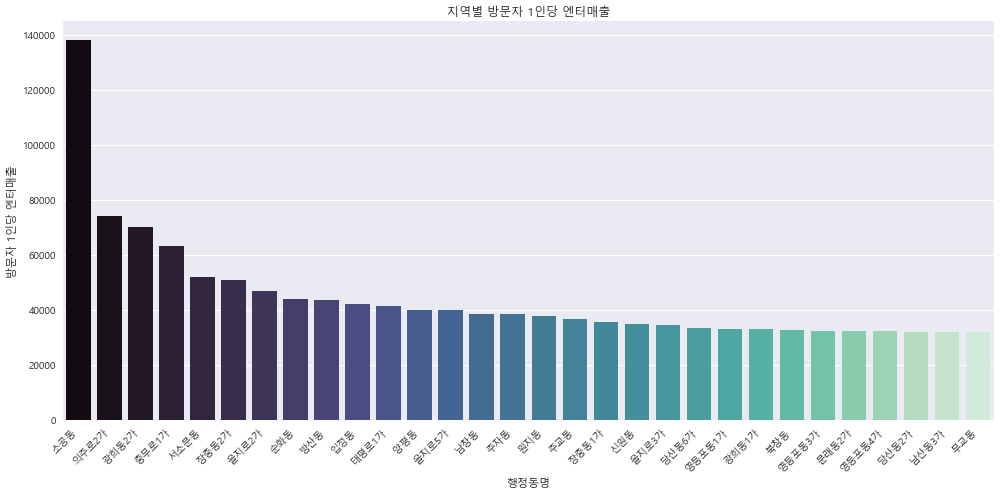

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 엔터 관련 방문횟수 합계 컬럼 생성
fp_card_scco_asset['엔터전체방문자수'] = fp_card_scco_asset[enter_count_columns].sum(axis=1)

# 1. 지역별로 엔터전체매출, 엔터전체방문자수 합계 집계
agg = fp_card_scco_asset.groupby('DISTRICT_KOR_NAME')[['엔터전체매출', '엔터전체방문자수']].sum().reset_index()

# 2. 방문자 1인당 엔터매출 계산
agg['방문자1인당엔터매출'] = agg['엔터전체매출'] / agg['엔터전체방문자수'].replace(0, np.nan)

# 3. 내림차순 정렬
agg = agg.sort_values('방문자1인당엔터매출', ascending=False).head(30)

# 4. 바차트 시각화
plt.figure(figsize=(14, 7))
sns.barplot(data=agg, x='DISTRICT_KOR_NAME', y='방문자1인당엔터매출', palette='rocket')
plt.title('지역별 방문자 1인당 엔터매출')
plt.xlabel('행정동명')
plt.ylabel('방문자 1인당 엔터매출')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<Figure size 864x720 with 0 Axes>

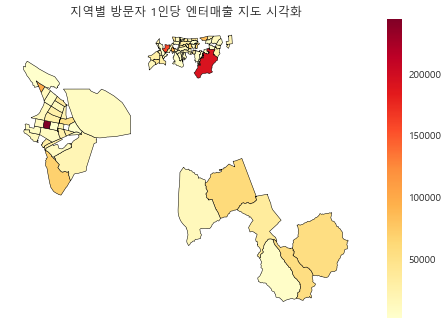

In [50]:
# 1. GeoDataFrame 생성 (GeoJSON 형식일 경우)
def geojson_to_shape(geojson_str):
    return shape(json.loads(geojson_str))

gdf = fp_card_scco_asset[['DISTRICT_KOR_NAME', '엔터전체매출', '엔터전체방문자수', 'DISTRICT_GEOM']].drop_duplicates('DISTRICT_KOR_NAME').copy()
gdf['geometry'] = gdf['DISTRICT_GEOM'].apply(geojson_to_shape)
gdf = gpd.GeoDataFrame(gdf, geometry='geometry')

# 2. 좌표계 지정 (위경도라고 가정)
gdf.set_crs(epsg=4326, inplace=True)

# 3. 방문자 1인당 엔터매출 계산
gdf['방문자1인당엔터매출'] = gdf['엔터전체매출'] / gdf['엔터전체방문자수'].replace(0, np.nan)

# 4. 지도 시각화
plt.figure(figsize=(12, 10))
gdf.plot(
    column='방문자1인당엔터매출',
    cmap='YlOrRd',
    legend=True,
    edgecolor='black',
    linewidth=0.5
)
plt.title('지역별 방문자 1인당 엔터매출 지도 시각화')
plt.axis('off')
plt.show()

방문자1인당엔터매출 = 엔터전체매출 / 엔터전체방문자수

### 유입 지수 계산

유입지수 = 방문자수 / 주거자수 + 근로자수

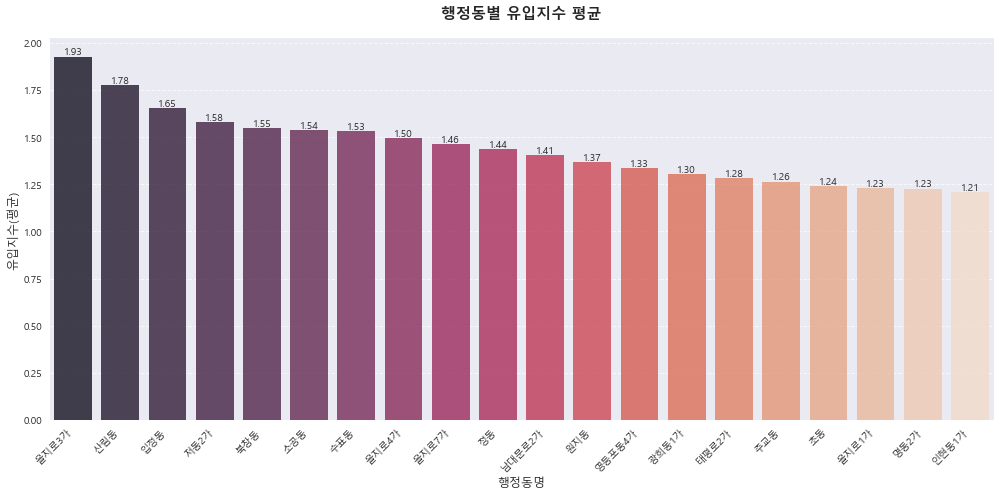

In [12]:
import seaborn as sns

#유입지수 계산
fp_card_scco_asset['유입지수'] = fp_card_scco_asset['VISITING_POPULATION'] / (
    fp_card_scco_asset['RESIDENTIAL_POPULATION'] + 
    fp_card_scco_asset['WORKING_POPULATION']
).replace(0, np.nan)

# DISTRICT_KOR_NAME별 유입지수 평균 집계
agg_inflow = fp_card_scco_asset.groupby('DISTRICT_KOR_NAME')['유입지수'].mean().reset_index()

# 유입지수 내림차순 정렬
agg_inflow_head = agg_inflow.sort_values('유입지수', ascending=False).head(20)

# 더 세련된 스타일 설정
plt.style.use('seaborn')
plt.figure(figsize=(14, 7))

#한글폰트
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 경로 설정
font_path = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

# 바 플롯 생성 및 커스터마이징
ax = sns.barplot(data=agg_inflow_head, x='DISTRICT_KOR_NAME', y='유입지수', 
                 palette='rocket', alpha=0.8)

# 바 위에 값 표시
for i, v in enumerate(agg_inflow_head['유입지수']):
    ax.text(i, v, f'{v:.2f}', ha='center', va='bottom')

# 제목과 레이블 스타일링
plt.title('행정동별 유입지수 평균', pad=20, fontsize=15, fontweight='bold')
plt.xlabel('행정동명', fontsize=12)
plt.ylabel('유입지수(평균)', fontsize=12)

# x축 레이블 회전 및 그리드 설정
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 테두리 스타일링
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

### 성별 연령별 1일평균 소비량

In [13]:
# 1. GENDER, AGE_GROUP, 날짜별 1인당 소비지수 평균 집계
daily_group = fp_card_scco_asset.groupby(['GENDER', 'AGE_GROUP', 'STANDARD_YEAR_MONTH'])['TOTAL_SALES'].mean().reset_index()


# 2. GENDER, AGE_GROUP별 1일 평균(즉, 일별 평균의 평균)
agg_gender_age = daily_group.groupby(['GENDER', 'AGE_GROUP'])['TOTAL_SALES'].mean().reset_index()

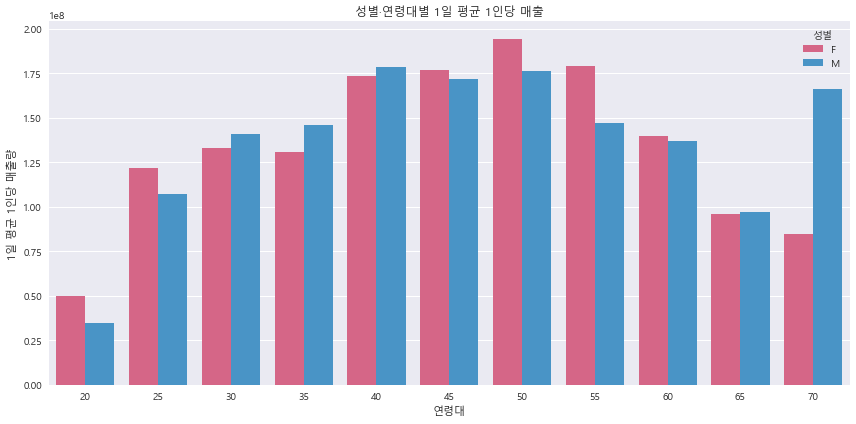

In [14]:
#한글폰트
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 경로 설정
font_path = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

# 남자는 파란색, 여자는 핑크색으로 컬러 지정
gender_palette = {'M': '#3498db', 'F': '#e75480'}  # 남: 파랑, 여: 핑크

plt.figure(figsize=(12, 6))
sns.barplot(data=agg_gender_age, x='AGE_GROUP', y='TOTAL_SALES', hue='GENDER', palette=gender_palette)
plt.title('성별·연령대별 1일 평균 1인당 매출')
plt.xlabel('연령대')
plt.ylabel('1일 평균 1인당 매출량')
plt.legend(title='성별')
plt.tight_layout()
plt.show()

### 전체 매출대비 엔터 매출 비율 시간별 추이

엔터매출비율 = 엔터전체매출 / TOTAL_SALES

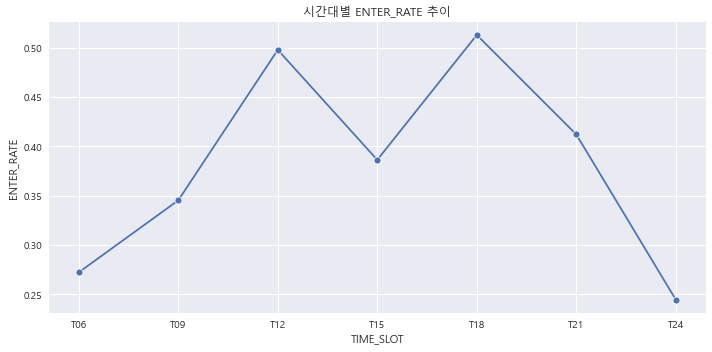

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. ENTER_RATE 계산 및 컬럼 추가
fp_card_scco_asset['엔터매출비율'] = fp_card_scco_asset['엔터전체매출'] / fp_card_scco_asset['TOTAL_SALES'].replace(0, np.nan)

# 2. NaN이 있는 행 제거
df = fp_card_scco_asset.dropna(subset=['엔터매출비율', 'TIME_SLOT'])

# 3. 시간대별 ENTER_RATE 평균 집계
timeslot = df.groupby('TIME_SLOT')['엔터매출비율'].mean().reset_index()

# 4. TIME_SLOT이 숫자라면 정렬
try:
    timeslot['TIME_SLOT'] = timeslot['TIME_SLOT'].astype(int)
    timeslot = timeslot.sort_values('TIME_SLOT')
except:
    timeslot = timeslot.sort_values('TIME_SLOT')

# 5. 시각화
plt.figure(figsize=(10, 5))
sns.lineplot(data=timeslot, x='TIME_SLOT', y='엔터매출비율', marker='o')
plt.title('시간대별 ENTER_RATE 추이')
plt.xlabel('TIME_SLOT')
plt.ylabel('ENTER_RATE')
plt.tight_layout()
plt.show()

### 전체 방문자수 대비 엔터 방문자수 비율 시간별 추이

엔터방문자비율 = 엔터전체방문자수 / TOTAL_COUNT

In [17]:
fp_card_scco_asset['엔터방문자비율'] = fp_card_scco_asset['엔터전체방문자수'] / fp_card_scco_asset['TOTAL_COUNT']

fp_card_scco_asset['INFLOW_IDX'] = fp_card_scco_asset['VISITING_POPULATION'] / (
                       fp_card_scco_asset['RESIDENTIAL_POPULATION'] + fp_card_scco_asset['WORKING_POPULATION'] + 1e-9)


### 연령별/성별 ENTER 매출 합계

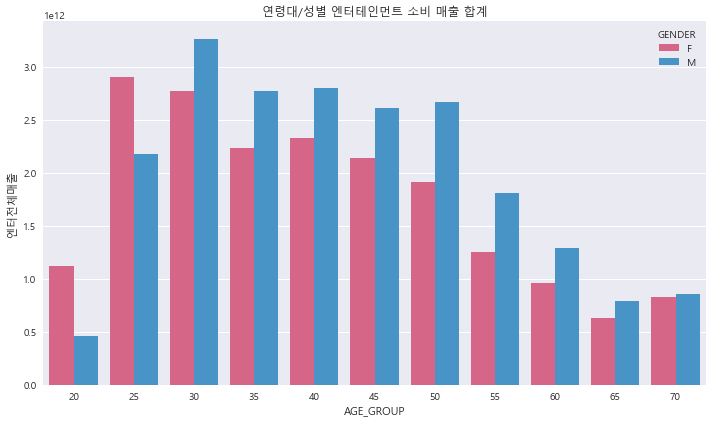

In [18]:
import seaborn as sns

# 연령대+성별 그룹별 ENTER_TOTAL_SALES 합계
age_gender_sales = fp_card_scco_asset.groupby(['AGE_GROUP', 'GENDER'])['엔터전체매출'].sum().reset_index()

# 남자는 파란색, 여자는 핑크색으로 컬러 지정
gender_palette = {'M': '#3498db', 'F': '#e75480'} 

plt.figure(figsize=(10, 6))
sns.barplot(data=age_gender_sales, x='AGE_GROUP', y='엔터전체매출', hue='GENDER', palette=gender_palette)
plt.title('연령대/성별 엔터테인먼트 소비 매출 합계')
plt.ylabel('엔터전체매출')
plt.xlabel('AGE_GROUP')
plt.legend(title='GENDER')
plt.tight_layout()
plt.show()

### 연령별/성별 1인당 엔터 소비액

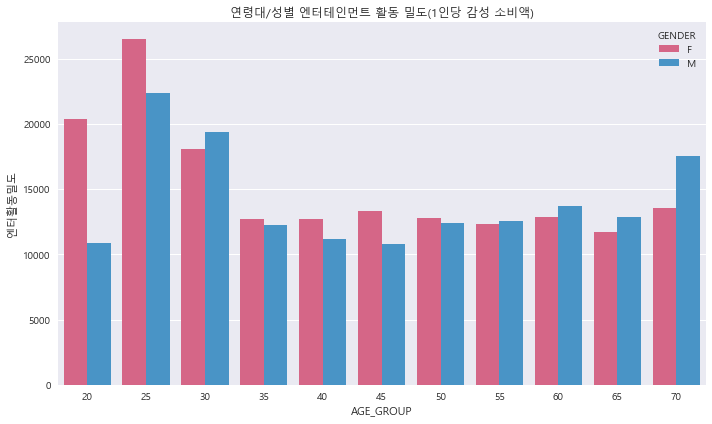

In [19]:
# 2) 활동밀도(1인당 감성 소비액) 계산
fp_card_scco_asset['엔터활동밀도'] = (
    fp_card_scco_asset['엔터전체매출'] /
    fp_card_scco_asset['전체인구'].replace(0, np.nan)  # 0으로 나누기 방지
)

# 연령대+성별 그룹별 ENTER_ACTIVITY_DENSITY 평균 계산 및 시각화
age_gender_density = fp_card_scco_asset.groupby(['AGE_GROUP', 'GENDER'])['엔터활동밀도'].mean().reset_index()

# 남자는 파란색, 여자는 핑크색으로 컬러 지정
gender_palette = {'M': '#3498db', 'F': '#e75480'} 

plt.figure(figsize=(10, 6))
sns.barplot(data=age_gender_density, x='AGE_GROUP', y='엔터활동밀도', hue='GENDER', palette=gender_palette)
plt.title('연령대/성별 엔터테인먼트 활동 밀도(1인당 감성 소비액)')
plt.ylabel('엔터활동밀도')
plt.xlabel('AGE_GROUP')
plt.legend(title='GENDER')
plt.tight_layout()
plt.show()

### 연령/성별 전체 방문횟수 합계

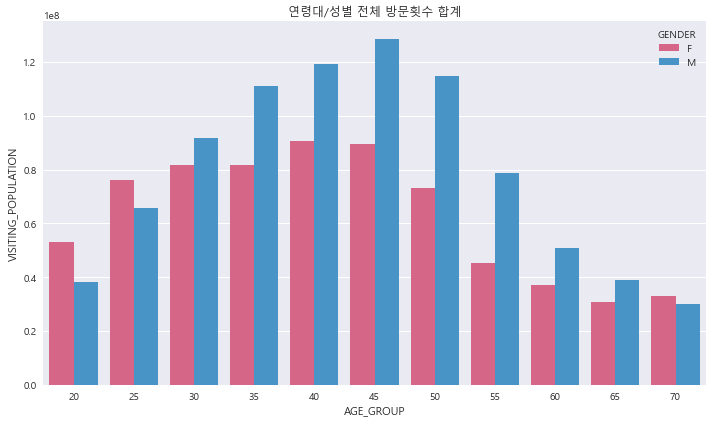

In [20]:
import seaborn as sns

# 연령대+성별 그룹별 ENTER_TOTAL_SALES 합계
age_gender_sales = fp_card_scco_asset.groupby(['AGE_GROUP', 'GENDER'])['VISITING_POPULATION'].sum().reset_index()

# 남자는 파란색, 여자는 핑크색으로 컬러 지정
gender_palette = {'M': '#3498db', 'F': '#e75480'} 

plt.figure(figsize=(10, 6))
sns.barplot(data=age_gender_sales, x='AGE_GROUP', y='VISITING_POPULATION', hue='GENDER', palette=gender_palette)
plt.title('연령대/성별 전체 방문횟수 합계')
plt.ylabel('VISITING_POPULATION')
plt.xlabel('AGE_GROUP')
plt.legend(title='GENDER')
plt.tight_layout()
plt.show()

### 연령/성별 엔터관련 방문횟수 합계

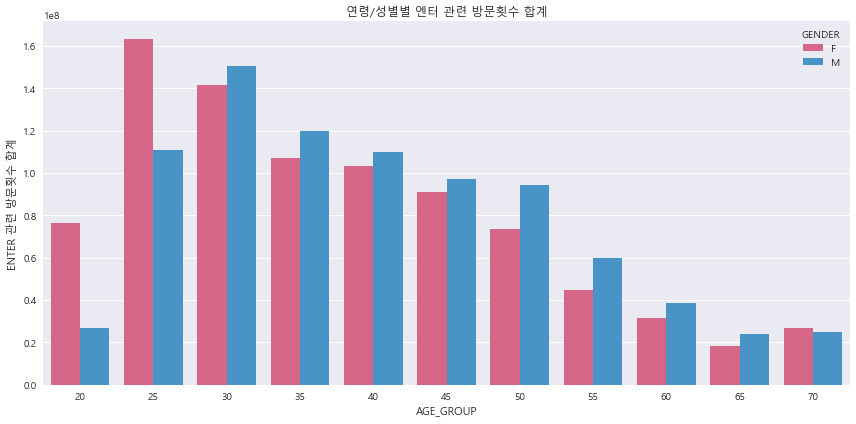

In [21]:
# 연령/성별별 엔터 관련 방문횟수 합계 집계
grouped = fp_card_scco_asset.groupby(['AGE_GROUP', 'GENDER'])['엔터전체방문자수'].sum().reset_index()

# 남자는 파란색, 여자는 핑크색으로 컬러 지정
gender_palette = {'M': '#3498db', 'F': '#e75480'} 

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped, x='AGE_GROUP', y='엔터전체방문자수', hue='GENDER', palette=gender_palette)
plt.title('연령/성별별 엔터 관련 방문횟수 합계')
plt.xlabel('AGE_GROUP')
plt.ylabel('ENTER 관련 방문횟수 합계')
plt.legend(title='GENDER')
plt.tight_layout()
plt.show()

### 엔터 매출 밀도(방문 1명당 매출)

엔터매출밀도 = 엔터전체매출 / 엔터전체방문자수

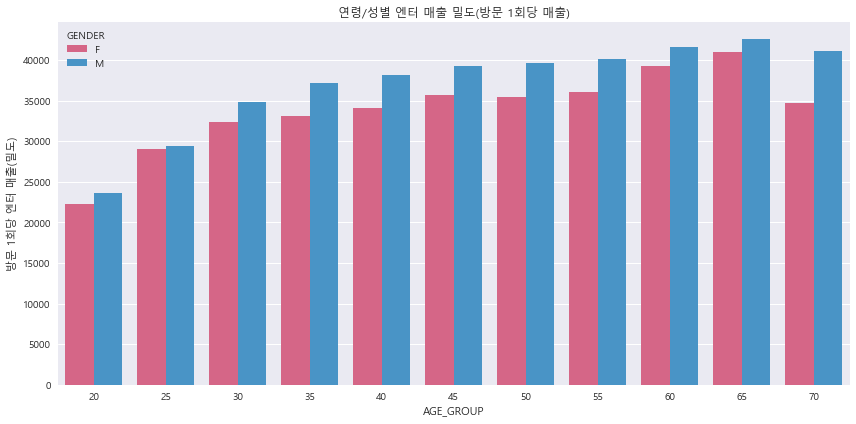

In [22]:
# 엔터 매출 밀도(방문 1회당 매출) 컬럼 생성
fp_card_scco_asset['엔터매출밀도'] = fp_card_scco_asset['엔터전체매출'] / fp_card_scco_asset['엔터전체방문자수'].replace(0, np.nan)

# 연령/성별별 엔터 매출 밀도 평균 집계
grouped = fp_card_scco_asset.groupby(['AGE_GROUP', 'GENDER'])['엔터매출밀도'].mean().reset_index()


# 남자는 파란색, 여자는 핑크색으로 컬러 지정
gender_palette = {'M': '#3498db', 'F': '#e75480'} 

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped, x='AGE_GROUP', y='엔터매출밀도', hue='GENDER', palette=gender_palette)
plt.title('연령/성별 엔터 매출 밀도(방문 1회당 매출)')
plt.xlabel('AGE_GROUP')
plt.ylabel('방문 1회당 엔터 매출(밀도)')
plt.legend(title='GENDER')
plt.tight_layout()
plt.show()

방문1회당 매출이 높은건 남성이 더 높은거로 나타났다.

비교적, 남성은 주로 방문보다는 구매에 초점이 맞춰져있고,

여성은 구매 보다는 방문에 초점이 맞춰져있다는것을 알수있다.

또한, 연령이 높아질수록 두 성별모두 구매에 초점을맞추는 경향이 짙어진다는것도 알수있다.

# 엔터 지수 예측 모델

### PCA(주성분 분석) 통해 가중치 조합 찾기 

##### FEEL_IDX : 종합감성지수 = 엔터소비활동지수
    - 즉시 소비력, 소비의 활력

In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

vars_emo = [
    '엔터전체매출',
    '유입지수',
    '엔터매출비율',
    '엔터전체방문자수',
    '엔터방문자비율',
    '엔터활동밀도',
    '엔터매출밀도'
]

# NaN이 있는 행 제거
X = fp_card_scco_asset[vars_emo].dropna()

# ① 표준화
X_std = StandardScaler().fit_transform(X)

# ② 첫 번째 주성분 추출
pc1 = PCA(n_components=1).fit_transform(X_std)

# ③ 0~1 스케일로 변환해 감성지수로 저장
pc1_norm = (pc1 - pc1.min()) / (pc1.max() - pc1.min() + 1e-9)

# 인덱스를 맞춰서 FEEL_IDX 할당
fp_card_scco_asset.loc[X.index, 'FEEL_IDX'] = pc1_norm

In [54]:
# ② PCA 객체 생성 및 학습
pca = PCA(n_components=1)
pca.fit(X_std)

# ③ 첫 번째 주성분의 loading(가중치) 추출
loadings = pca.components_[0]

# ④ 보기 좋게 데이터프레임으로 출력
weights_df = pd.DataFrame({'칼럼명': vars_emo, '가중치(loading)': loadings})
print(weights_df)

        칼럼명  가중치(loading)
0    엔터전체매출      0.564407
1      유입지수      0.047140
2    엔터매출비율      0.104359
3  엔터전체방문자수      0.617971
4   엔터방문자비율      0.120349
5    엔터활동밀도      0.517641
6    엔터매출밀도      0.063302


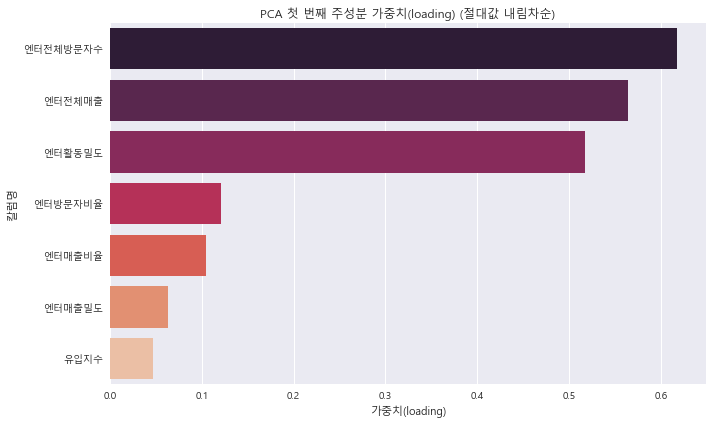

In [55]:
weights_df_sorted = weights_df.reindex(weights_df['가중치(loading)'].abs().sort_values(ascending=False).index)

plt.figure(figsize=(10, 6))
sns.barplot(data=weights_df_sorted, x='가중치(loading)', y='칼럼명', palette='rocket')
plt.title('PCA 첫 번째 주성분 가중치(loading) (절대값 내림차순)')
plt.xlabel('가중치(loading)')
plt.ylabel('칼럼명')
plt.tight_layout()
plt.show()

In [26]:
fp_card_scco_asset['FEEL_IDX']

0          0.006936
1          0.006936
2          0.001663
3          0.001663
4          0.000691
             ...   
6454697    0.013696
6454698    0.001997
6454699         NaN
6454700    0.010246
6454701         NaN
Name: FEEL_IDX, Length: 6454702, dtype: float64

# 감성지수와 각 변수별 산점도 시각화

C:\Users\82106\AppData\Local\Temp\ipykernel_24760\1710878054.py:28: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
c:\Users\82106\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


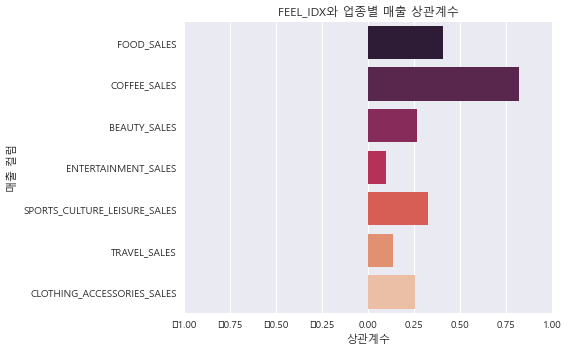

In [47]:
# sales_columns 예시 (원하는 컬럼명으로 수정)
sales_columns = [
    'FOOD_SALES',
    'COFFEE_SALES',
    'BEAUTY_SALES',
    'ENTERTAINMENT_SALES',
    'SPORTS_CULTURE_LEISURE_SALES',
    'TRAVEL_SALES',
    'CLOTHING_ACCESSORIES_SALES'
]

# FEEL_IDX와 sales_columns만 추출
corr_df = fp_card_scco_asset[['FEEL_IDX'] + sales_columns].dropna()

# 상관계수 계산
corr = corr_df.corr()

# FEEL_IDX와 각 sales 컬럼의 상관계수만 추출
feel_corr = corr.loc[sales_columns, 'FEEL_IDX']

# 1. 바차트로 시각화
plt.figure(figsize=(8, 5))
sns.barplot(x=feel_corr.values, y=feel_corr.index, palette='rocket')
plt.title('FEEL_IDX와 업종별 매출 상관계수')
plt.xlabel('상관계수')
plt.ylabel('매출 컬럼')
plt.xlim(-1, 1)
plt.tight_layout()
plt.show()

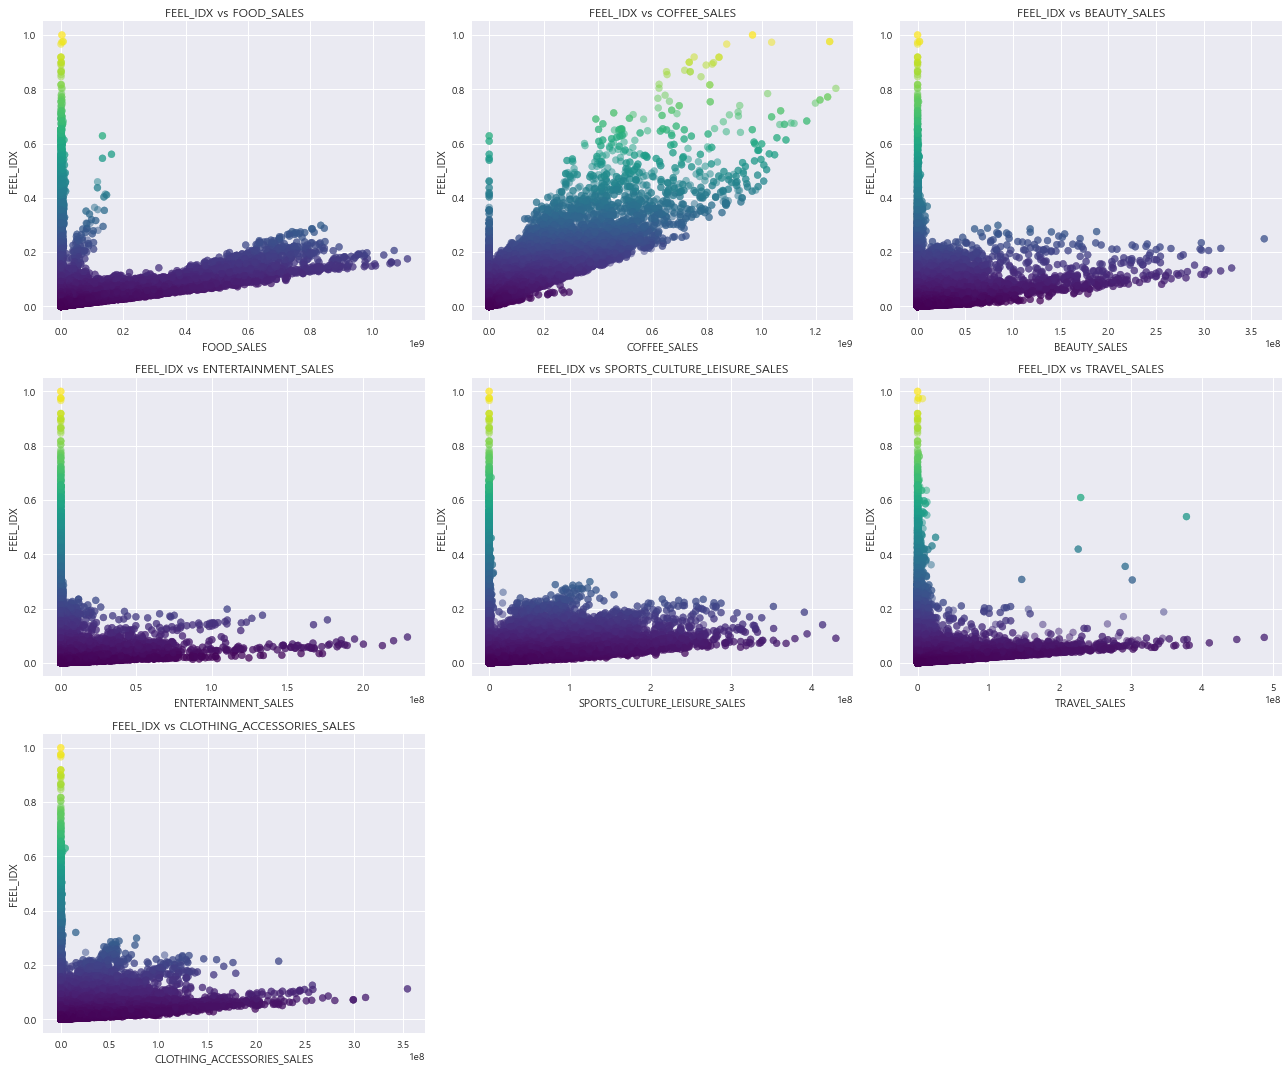

In [27]:
sales_columns = [
    'FOOD_SALES',
    'COFFEE_SALES',
    'BEAUTY_SALES',
    'ENTERTAINMENT_SALES',
    'SPORTS_CULTURE_LEISURE_SALES',
    'TRAVEL_SALES',
    'CLOTHING_ACCESSORIES_SALES'
]

n_cols = 3
n_rows = (len(sales_columns) + n_cols - 1) // n_cols

plt.figure(figsize=(6 * n_cols, 5 * n_rows))

for i, col in enumerate(sales_columns):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.scatter(fp_card_scco_asset[col], fp_card_scco_asset['FEEL_IDX'], 
                c=fp_card_scco_asset['FEEL_IDX'], 
                cmap='viridis',
                alpha=0.5)
    plt.xlabel(col)
    plt.ylabel('FEEL_IDX')
    plt.title(f'FEEL_IDX vs {col}')

plt.tight_layout()
plt.show()

c:\Users\82106\anaconda3\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
C:\Users\82106\AppData\Local\Temp\ipykernel_24760\719483456.py:23: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
c:\Users\82106\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


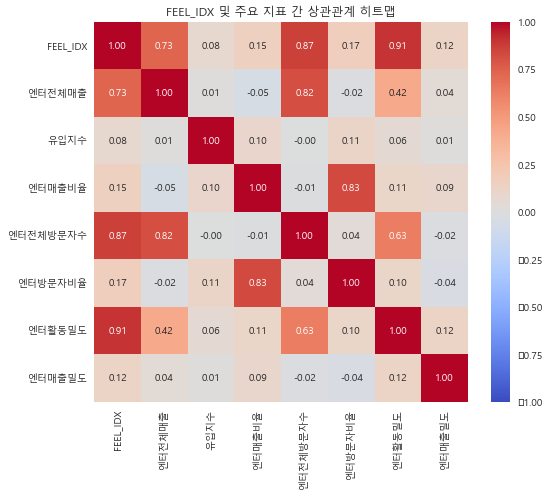

C:\Users\82106\AppData\Local\Temp\ipykernel_24760\719483456.py:35: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
c:\Users\82106\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


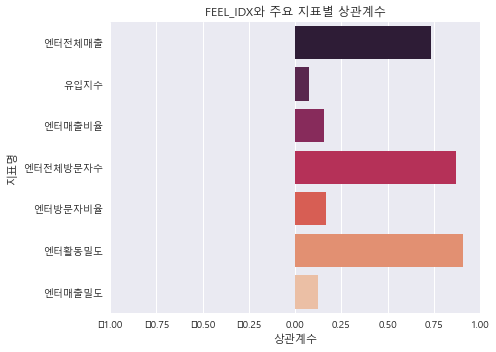

In [52]:
# 분석할 칼럼 리스트
columns = [
    'FEEL_IDX',
    '엔터전체매출',
    '유입지수',
    '엔터매출비율',
    '엔터전체방문자수',
    '엔터방문자비율',
    '엔터활동밀도',
    '엔터매출밀도'
]

# 결측치 제거
corr_df = fp_card_scco_asset[columns].dropna()

# 상관계수 계산
corr = corr_df.corr()

# 1. 히트맵 시각화
plt.figure(figsize=(8, 7))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title('FEEL_IDX 및 주요 지표 간 상관관계 히트맵')
plt.tight_layout()
plt.show()

# 2. FEEL_IDX와 나머지 칼럼의 상관계수만 바차트로
feel_corr = corr.loc[columns[1:], 'FEEL_IDX']

plt.figure(figsize=(7, 5))
sns.barplot(x=feel_corr.values, y=feel_corr.index, palette='rocket')
plt.title('FEEL_IDX와 주요 지표별 상관계수')
plt.xlabel('상관계수')
plt.ylabel('지표명')
plt.xlim(-1, 1)
plt.tight_layout()
plt.show()

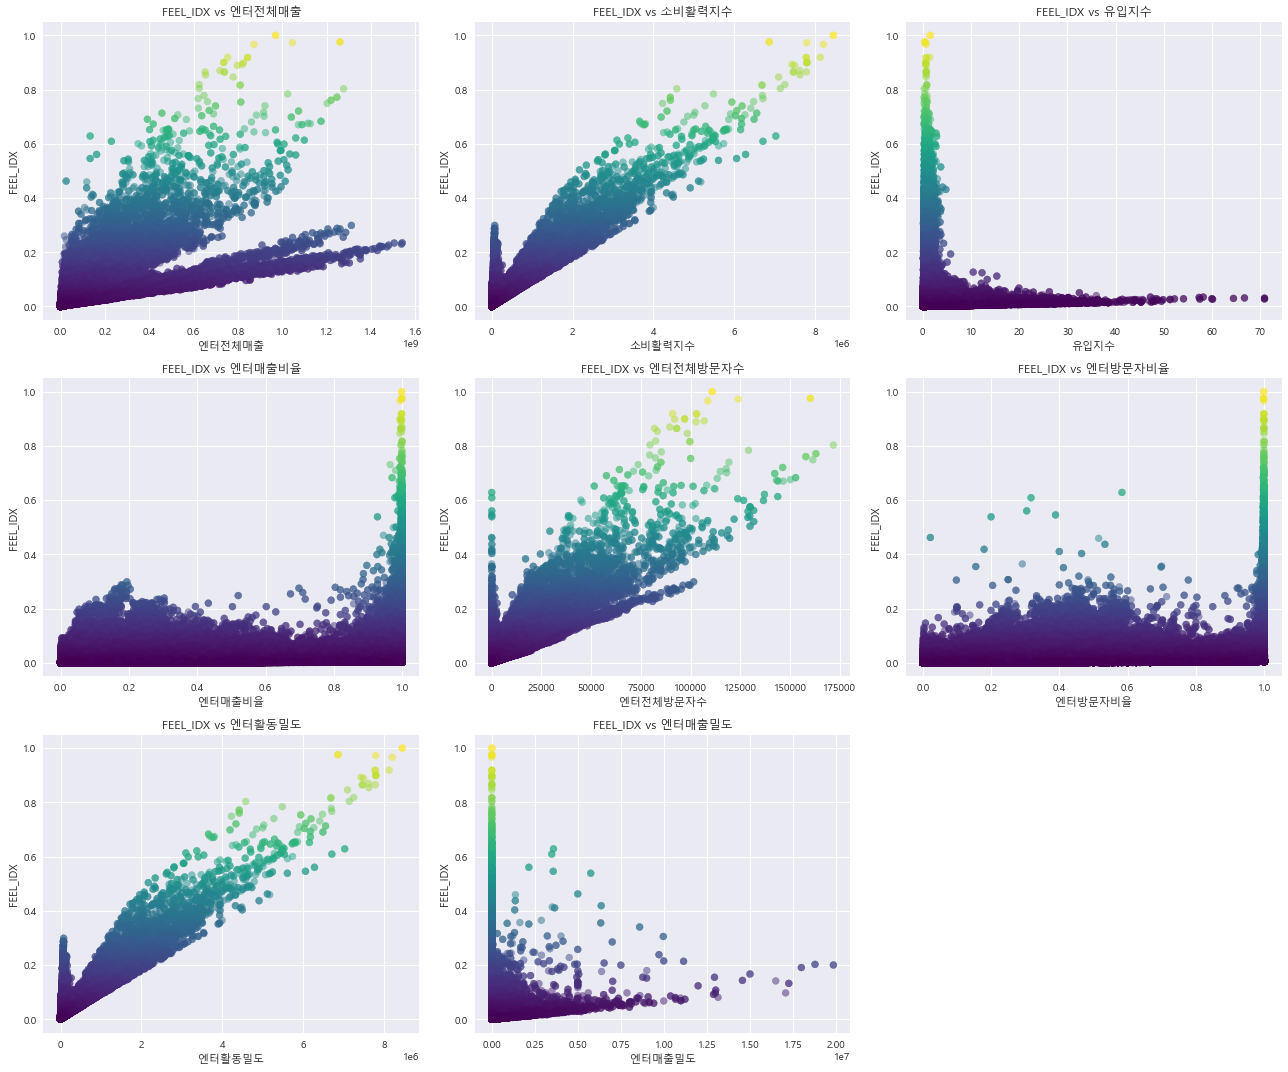

In [28]:
columns = [
    '엔터전체매출',
    '유입지수',
    '엔터매출비율',
    '엔터전체방문자수',
    '엔터방문자비율',
    '엔터활동밀도',
    '엔터매출밀도'
]

n_cols = 3
n_rows = (len(columns) + n_cols - 1) // n_cols

plt.figure(figsize=(6 * n_cols, 5 * n_rows))

for i, col in enumerate(columns):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.scatter(fp_card_scco_asset[col], fp_card_scco_asset['FEEL_IDX'],
                c=fp_card_scco_asset['FEEL_IDX'], 
                cmap='viridis',
                alpha=0.5)
    plt.xlabel(col)
    plt.ylabel('FEEL_IDX')
    plt.title(f'FEEL_IDX vs {col}')

plt.tight_layout()
plt.show()